# Self-Driving Car Engineer Nanodegree
## Project: Advanced Lane Finding


# Camera calibration

In the following code camera calibration is performed. The code is based on [Udacity's](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb) example.

In [1]:
# Load necessary modules and set up
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

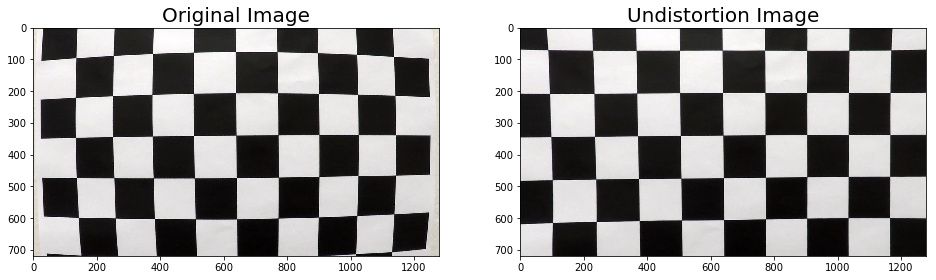

In [2]:
# prepare object points
nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('./camera_cal/cali*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name ='./output_images/camera_cal/'+'corners_found'+str(idx+1)+'.jpg'
        cv2.imwrite(write_name, img)


# Test undistortion on a calibration image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

dst = cv2.undistort(img, mtx, dist, None, mtx)

write_name ='./output_images/camera_cal/undistortied_calibration1.jpg'
mpimg.imsave(write_name, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistortion Image', fontsize=20)

# Pipeline (test images)

## Distortion correction that was calculated via camera calibration applied to each test image. 

cameraMatrix: 
 [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
distCoeffs: 
 [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


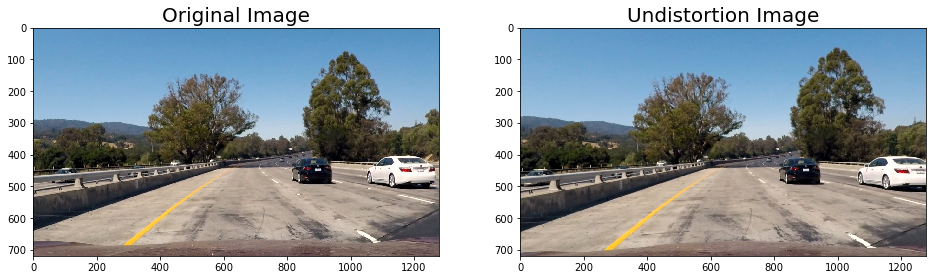

In [3]:
# Undistortion test images

# Load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

print('cameraMatrix: \n', mtx)
print('distCoeffs: \n', dist)

# Read the list of test images
images_test = glob.glob('./test_images/test*.jpg')
images_origin = []
images_undist = []

for idx, fname in enumerate(images_test):
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    images_origin.append(img)
    images_undist.append(dst)

    write_name = './output_images/test_images/'+'undistorted'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.imshow(images_origin[0])
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(images_undist[0])
ax2.set_title('Undistortion Image', fontsize=20)

## Create of thresholded binary image


The code for these operations is presented under Create of thresholded binary image header. Different transformation, such as Sobel transformation (including X with Y threshold, and magnitude with direction threshold), as well as saturation, hue and red channels binary thresholds were implemented.

Unfortunately, the optimal combination of these filters which is able to separate pixels of lane line from background on snapshots from all three videos was not found. Shadows and glares are quite challenging. And Sobel transformation may import noise (such as edge of the road or different road material in the challenge video).

That is why I change the sequence of "Create of thresholded binary image" and "Perspective transform to a bird-eye view", to first find the region of interest of the road, then use adaptive methods, such as scaling saturation and red channel, histogram equalization to optimise the binary image result. 

A combination of the yellow in HSV color space and saturation channels for the yellow line.
A combination of the white in HSV color space and red channels for the white line.

In [4]:
# Binary Image

# Sobel gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with sobel function and take the absolute value
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        abs_sobel = 0
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sobel_binary

# Magnitude of Sobel gradient
def mag_sobel_thresh(img, sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Tkae both sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit interger
    scaled_gradmag = np.uint8(255 * gradmag / np.max(gradmag))
    # Create a copy and apply the threshold
    gradmag_ninary = np.zeros_like(scaled_gradmag)
    gradmag_ninary[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1

    return gradmag_ninary

# Direction of Sobel gradient
def dir_sobel_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    graddir_binary = np.zeros_like(absgraddir)
    graddir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return graddir_binary

# Binary saturation channel threshold with scale
def s_thresh(img, thresh=(0,255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    return s_binary, s_channel

# Binary red channel threshold with scale
def r_thresh(img, thresh=(0,255)):
    r_channel = img[:,:,0]
    # Threshold color channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= thresh[0]) & (r_channel <= thresh[1])] = 1

    return r_binary, r_channel

# Color in range of yellow and white
def color_range(img):
    # Convert to HSV color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Threshold yellow and white
    yellow_lower = np.array([15, 65, 65])
    yellow_upper = np.array([30, 255, 255])
    white_lower = np.array([0, 0, 195])
    white_upper = np.array([255, 30, 255])
    # Threshold the RBG image to get only yellow and white colors
    yellow = cv2.inRange(hsv, yellow_lower, yellow_upper)
    white = cv2.inRange(hsv, white_lower, white_upper)
        
    return yellow, white

# Combine sobel grandient and color binary
def combined_thresh(img):
    
    # Sobel X and Y threshold
    absx_bin = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20,100))
    absy_bin = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20,50))
    # Sobel magtitude and direction threshold
    mag_bin = mag_sobel_thresh(img, sobel_kernel=3, thresh=(30,60))
    dir_bin = dir_sobel_thresh(img, sobel_kernel=15, thresh=(0.8,1.2))
    
    # Saturation channel threshold
    s_bin, s_cha = s_thresh(img, thresh=(90,255))
    # Red channel threshold
    r_bin, r_cha = r_thresh(img, thresh=(200,255))
    # Color in yellow and white range
    y_bin, w_bin = color_range(img) 
    
    combined = np.zeros_like(absx_bin)
    
    # Sobel threshold result bit or with color mask
    combined[((absx_bin == 1) & (absy_bin == 1))| # Sobel X and Y binary
            ((mag_bin == 1) & (dir_bin == 1)) |  # Sobel magtitude and direction binary
            ((y_bin >= 1) & (s_bin == 1)) |      # Color in yellow with saturation binary
            (w_bin >= 1) & (r_bin == 1)] = 1      # Color in white with red binary

    return combined, absx_bin, absy_bin, mag_bin, dir_bin, s_bin, r_bin, y_bin, w_bin

# Combine color binary of yellow and white
def combined_color(img):
    # Get S channel from HLS space
    _, s_channel = s_thresh(img)
    # Get R channel from RGB space
    _, r_channel = r_thresh(img)
    # Get yellow and white in range from HSV space
    y_bin, w_bin = color_range(img)
    
    combined_channel = (s_channel + 0.5 * r_channel) / 1.5
    yellow_channel = 0.3 * y_bin + 0.6* s_channel + 0.3 * r_channel
    white_channel = 0.2 * w_bin + 0.8 * r_channel
    
    return combined_channel, yellow_channel, white_channel

def color_thresh(warped, y_thresh=(80,255), w_thresh=(140,255)):
    
    combined, yellow, white = combined_color(warped)
    # Rescale to 8 bit interger
    scaled_yellow = np.uint8(255 * yellow / np.max(yellow))
    scaled_white = np.uint8(255 * white / np.max(white))
    # Apply a threshold, and create a binary image result
    yellow_binary = np.zeros_like(yellow)
    yellow_binary[(scaled_yellow >= y_thresh[0]) & (scaled_yellow <= y_thresh[1])] = 1
    white_binary = np.zeros_like(white)
    white_binary[(scaled_white >= w_thresh[0]) & (scaled_white <= w_thresh[1])] = 1
    
    combined = np.zeros_like(yellow)
    combined[(yellow_binary == 1) | (white_binary == 1)] = 1

    return combined, yellow_binary, white_binary

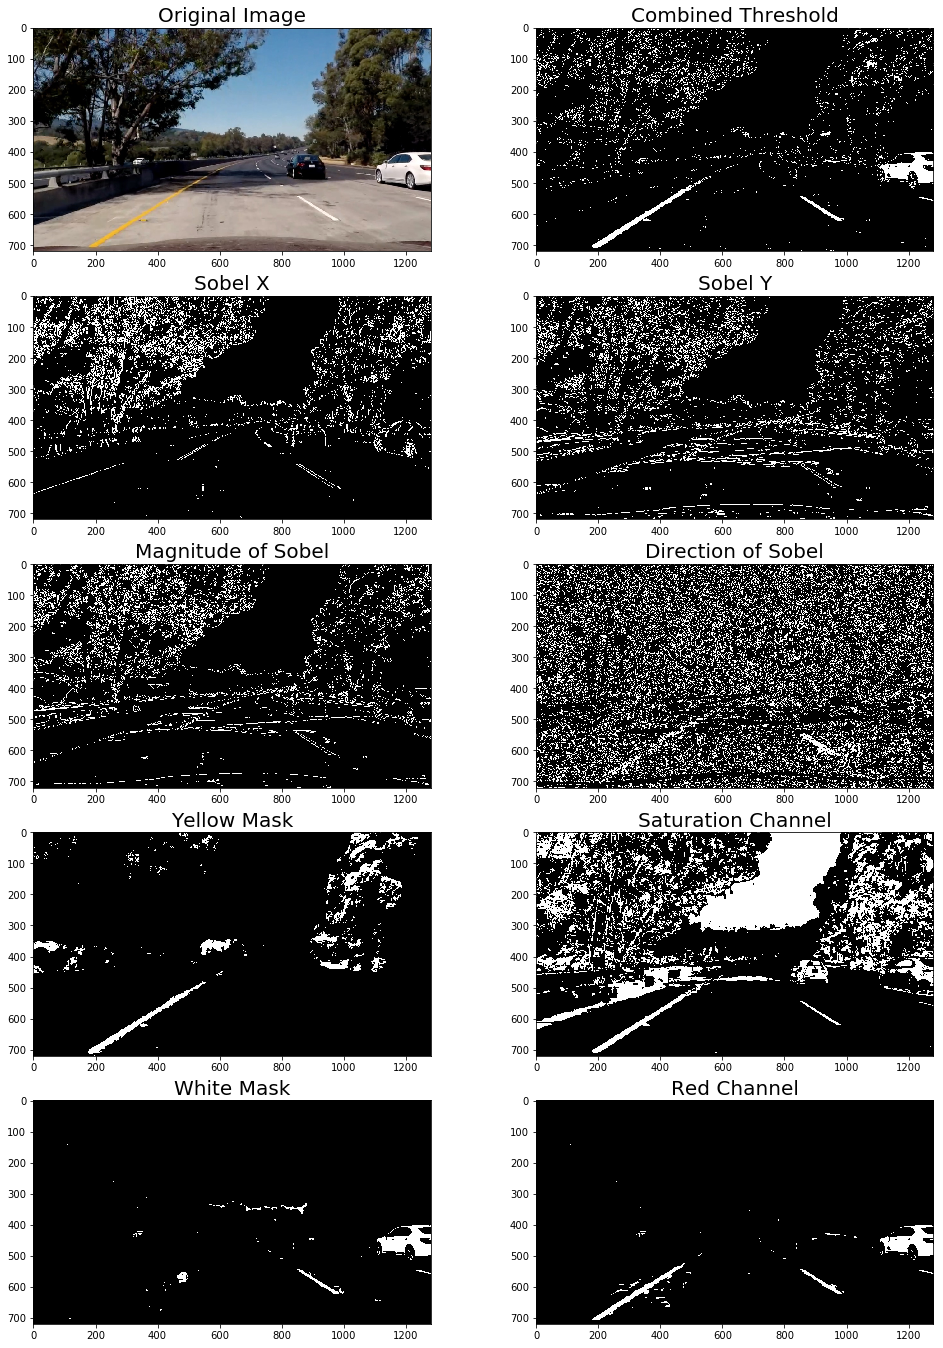

In [5]:
# Read in an undistortion image
image_undist = images_undist[4]

# Run the function "Combine sobel grandient and color binary"
combined_test, absx_bin, absy_bin, mag_bin, dir_bin, s_bin, r_bin, y_bin, w_bin = combined_thresh(image_undist)

# Plot the result
fig = plt.subplots(5, 2, figsize=(16, 20))

ax1 = plt.subplot(5,2,1)
ax1.imshow(image_undist)
ax1.set_title('Original Image', fontsize=20)
ax2 = plt.subplot(5,2,2)
ax2.imshow(combined_test, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=20)
ax3 = plt.subplot(5,2,3)
ax3.imshow(absx_bin, cmap='gray')
ax3.set_title('Sobel X', fontsize=20)
ax4 = plt.subplot(5,2,4)
ax4.imshow(absy_bin, cmap='gray')
ax4.set_title('Sobel Y', fontsize=20)
ax5 = plt.subplot(5,2,5)
ax5.imshow(mag_bin, cmap='gray')
ax5.set_title('Magnitude of Sobel', fontsize=20)
ax6 = plt.subplot(5,2,6)
ax6.imshow(dir_bin, cmap='gray')
ax6.set_title('Direction of Sobel', fontsize=20)
ax7 = plt.subplot(5,2,7)
ax7.imshow(y_bin, cmap='gray')
ax7.set_title('Yellow Mask', fontsize=20)
ax8 = plt.subplot(5,2,8)
ax8.imshow(s_bin, cmap='gray')
ax8.set_title('Saturation Channel', fontsize=20)
ax9 = plt.subplot(5,2,9)
ax9.imshow(w_bin, cmap='gray')
ax9.set_title('White Mask', fontsize=20)
ax10 = plt.subplot(5,2,10)
ax10.imshow(r_bin, cmap='gray')
ax10.set_title('Red Channel', fontsize=20)

plt.subplots_adjust(left=0., right=0.8, top=0.9, bottom=0.)

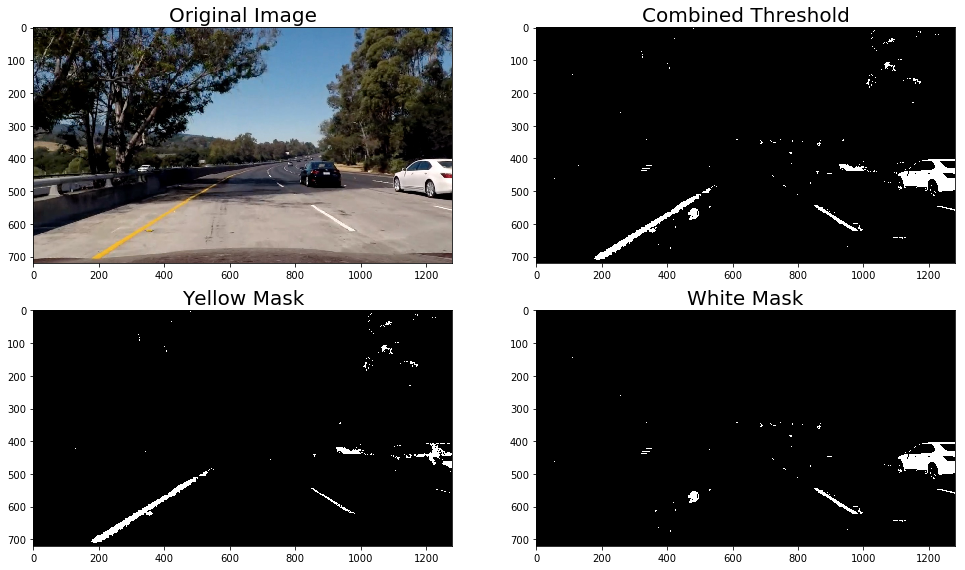

In [6]:
# Run the function "Combine color binary of yellow and white"
color_test, y_bin, w_bin = color_thresh(image_undist, y_thresh=(140,255), w_thresh=(200,255))

# Plot the result
fig = plt.subplots(2, 2, figsize=(16, 8))

ax1 = plt.subplot(2,2,1)
ax1.imshow(image_undist)
ax1.set_title('Original Image', fontsize=20)
ax2 = plt.subplot(2,2,2)
ax2.imshow(color_test, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=20)
ax3 = plt.subplot(2,2,3)
ax3.imshow(y_bin, cmap='gray')
ax3.set_title('Yellow Mask', fontsize=20)
ax4 = plt.subplot(2,2,4)
ax4.imshow(w_bin, cmap='gray')
ax4.set_title('White Mask', fontsize=20)

plt.subplots_adjust(left=0., right=0.8, top=0.9, bottom=0.)

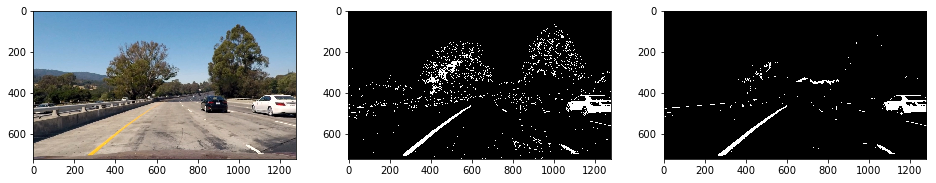

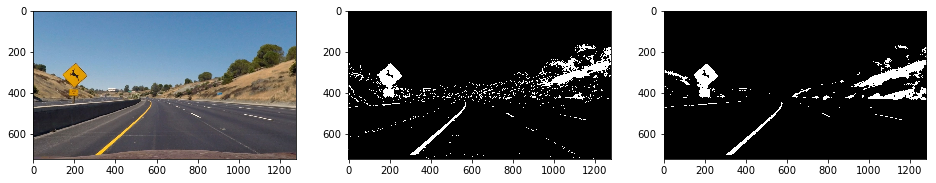

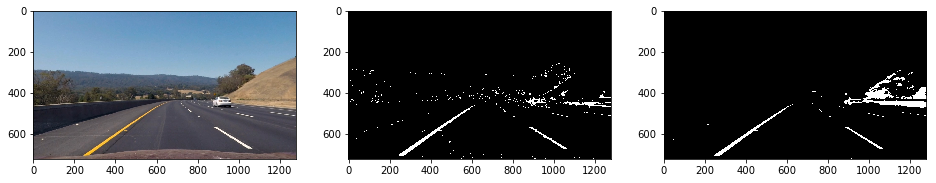

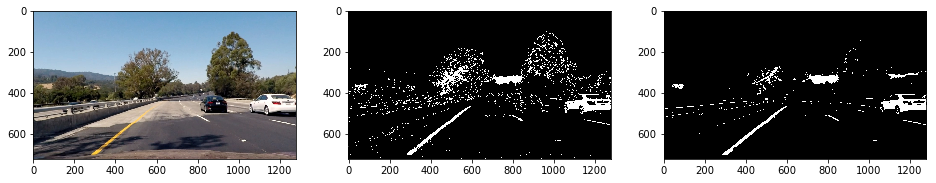

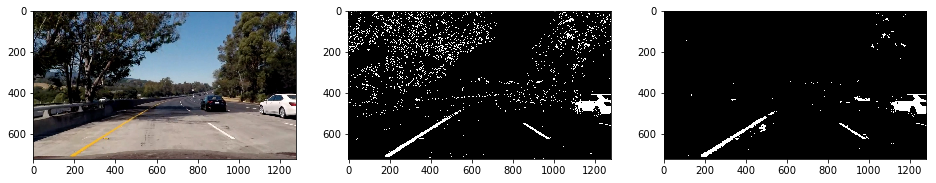

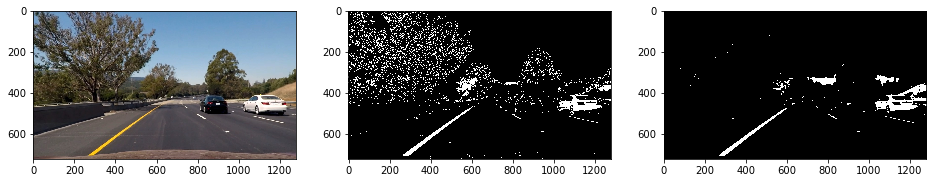

In [7]:
# Read the list of undistorted images, generate the binary images
images_binary_combine = []
images_binary_color = []

for idx, img in enumerate(images_undist):
    combine_thd, _, _, _, _, _, _, _, _ = combined_thresh(img)
    color_thd, _, _ = color_thresh(img, y_thresh=(140,255), w_thresh=(200,255))
    images_binary_combine.append(combine_thd)
    images_binary_color.append(color_thd)

    write_name = './output_images/test_images/'+'binary_combine'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, combine_thd, cmap='gray')
    write_name = './output_images/test_images/'+'binary_color'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, color_thd, cmap='gray')
    
    fig = plt.figure(figsize=(16, 80))
    fig.add_subplot(1,3,1)
    plt.imshow(img)
    fig.add_subplot(1,3,2)
    plt.imshow(combine_thd, cmap='gray')
    fig.add_subplot(1,3,3)
    plt.imshow(color_thd, cmap='gray')
    plt.show()

In [8]:
## Perspective transform to a bird-eye view

In [9]:
# Compute the perspective transform and warp the images
def perspective_transform(img):

    img_size = (img.shape[1], img.shape[0])
        
    # Four source coordinates
    src = np.float32(
        [[188, 720],
         [1125, 720],
         [593, 450],
         [687, 450]])
    # Four desired coordinates
    dst = np.float32(
        [[310, 720],
         [1010, 720],
         [310, 0],
         [1010, 0]])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

def draw_straight_line(img):
    
    cv2.line(img, (188, 720), (593, 450), color=(255,0,0), thickness=1)
    cv2.line(img, (1125, 720), (687, 450), color=(255,0,0), thickness=1)
    
    return img

M = 
 [[ -5.33943555e-01  -1.53919824e+00   9.87040427e+02]
 [ -2.44249065e-15  -1.90592423e+00   8.57665904e+02]
 [ -1.51788304e-18  -2.38155776e-03   1.00000000e+00]]
Minv = 
 [[  1.34285714e-01  -7.97416400e-01   5.51371429e+02]
 [ -2.22044605e-15  -5.24679829e-01   4.50000000e+02]
 [ -3.90312782e-18  -1.24955532e-03   1.00000000e+00]]


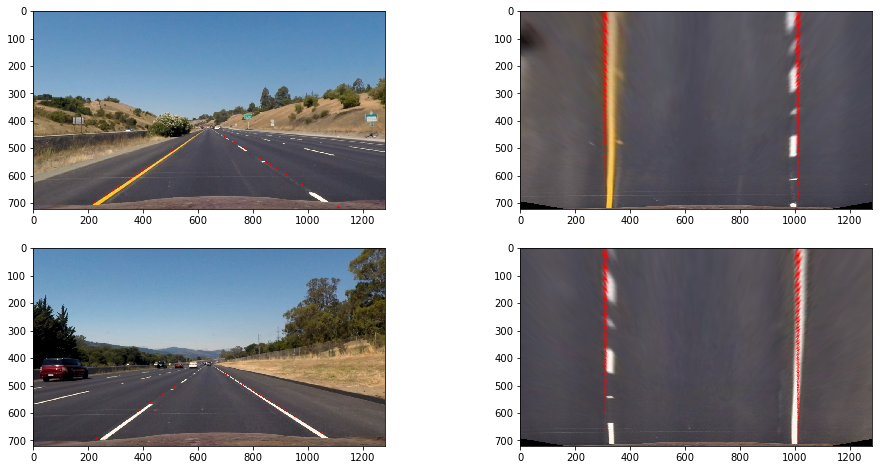

In [10]:
# Test the two straight images with perspective transform
img_straight1 = mpimg.imread('test_images/straight_lines1.jpg')
img_straight1 = cv2.undistort(img_straight1, mtx, dist, None, mtx)
img_straight1 = draw_straight_line(img_straight1)
warped_straight1, M, Minv = perspective_transform(img_straight1)

img_straight2 = mpimg.imread('test_images/straight_lines2.jpg')
img_straight2 = cv2.undistort(img_straight2, mtx, dist, None, mtx)
img_straight2 = draw_straight_line(img_straight2)
warped_straight2, M, Minv = perspective_transform(img_straight2)

print('M = \n', M)
print('Minv = \n', Minv)

fig = plt.subplots(2, 2, figsize=(16, 8))
ax1 = plt.subplot(2,2,1)
ax1.imshow(img_straight1)
ax2 = plt.subplot(2,2,2)
ax2.imshow(warped_straight1)
ax3 = plt.subplot(2,2,3)
ax3.imshow(img_straight2)
ax4 = plt.subplot(2,2,4)
ax4.imshow(warped_straight2)

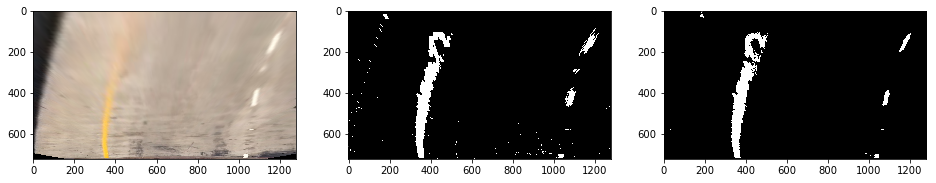

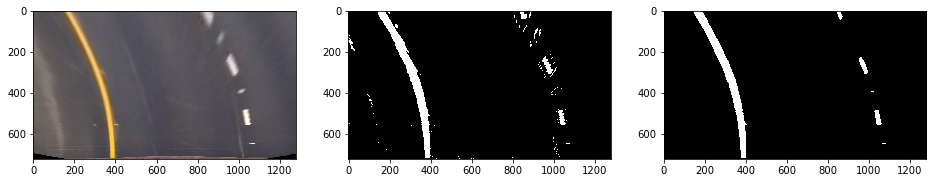

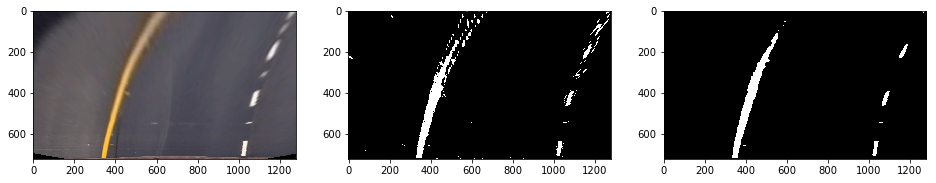

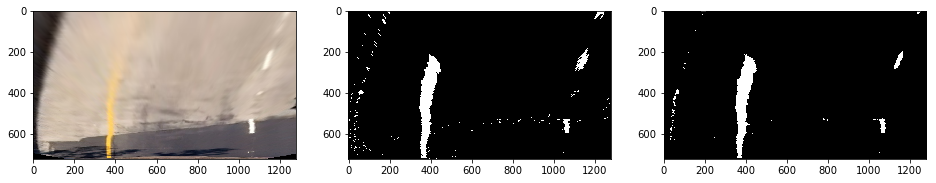

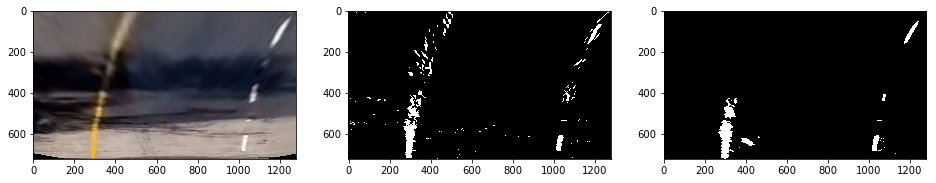

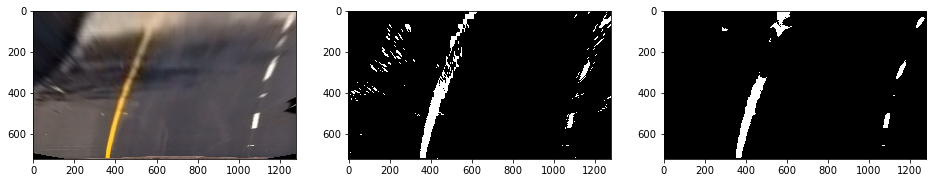

In [11]:
# Read the list of test binary images, generate the binary warped images and the color warped images
images_warped = []
images_warped_combine = []
images_warped_color = []

for idx, img in enumerate(images_undist):
    warped, _, _ = perspective_transform(img)
    images_warped.append(warped)
    
    write_name = './output_images/test_images/'+'warped'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, warped)

for idx, img in enumerate(images_binary_combine):
    warped_combine, _, _ = perspective_transform(img)
    images_warped_combine.append(warped_combine)
    
    write_name = './output_images/test_images/'+'warped_combine'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, warped_combine, cmap='gray')
    
for idx, img in enumerate(images_warped):
    warped_color, _, _ = color_thresh(img, y_thresh=(140,255), w_thresh=(200,255))
    images_warped_color.append(warped_color)
    
    write_name = './output_images/test_images/'+'warped_color'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, warped_color, cmap='gray')

for idx in range(len(images_undist)): 
    fig = plt.figure(figsize=(16, 8))
    fig.add_subplot(1,3,1)
    plt.imshow(images_warped[idx])
    fig.add_subplot(1,3,2)
    plt.imshow(images_warped_combine[idx], cmap='gray')
    fig.add_subplot(1,3,3)
    plt.imshow(images_warped_color[idx], cmap='gray')
    plt.show()

## Identify lane-line pixels and fit their positions with a polynomial


In [12]:
def draw_line_fit(out_img, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )

    # Draw the fitted line onto the warped blank image
    if left_fit.any():
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_line_pts), isClosed=False, color=(255,255,0), thickness=3)
    if right_fit.any():
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_line_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(right_line_pts), isClosed=False, color=(255,255,0), thickness=3)
       
    return out_img

def draw_line_region(out_img, left_fit, right_fit, margin=100):
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    
    if left_fit.any():
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        
    if right_fit.any():
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
  
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

# Sliding Window search with hostogram
def sliding_window_search(binary_warped, nwindows=9, margin=100, minpix=50, bias=200):
    """
    Sliding window search method. It's used to locate lane pixels from scratch, given no previous information.
    Input: binary_warped: binary image with birds' eye view,
           nwindows: number of sliding windows
           margin: width of the windows +/- margin
           minpix: minimum number of pixels found to recenter window
           bias: bias pixel of line base
    Ouput: left and right fitted x,y and a diagnosis image.
    """
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    leftpoint = np.int(histogram.shape[0]/2 - bias)
    rightpoint = np.int(histogram.shape[0]/2 + bias)
    leftx_base = np.argmax(histogram[:leftpoint])
    rightx_base = np.argmax(histogram[rightpoint:]) + rightpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set minimum number of pixels found to recenter window
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_fit = []
    right_fit = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    if leftx.any():
        left_fit = np.polyfit(lefty, leftx, 2)
    if rightx.any():
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Create an output image to draw on and  visualize the result
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Visualization of the fitted line and shadow area
    out_img = draw_line_fit(out_img, left_fit, right_fit)
    out_img = draw_line_region(out_img, left_fit, right_fit, margin=margin)
    
    return out_img, left_fit, right_fit
    
    
def prev_search(binary_warped, left_fit_last, right_fit_last, margin=100):
    """
    Search lane pixels within a polynomial ROI given the previous left and right lane polynomial function.
    Input: binary_warped: a binary image from birds' eye view, 
           left_fit, right_fit: left lane and right lane polynomial function,
           margin: width of the windows +/- margin
    Output: fitted left/right lane lines, a diagnosis image.
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = []
    right_lane_inds = []
    left_fit = []
    right_fit = []
    
    if left_fit_last.any():  
        left_lane_inds = ((nonzerox > (left_fit_last[0]*(nonzeroy**2) + left_fit_last[1]*nonzeroy + left_fit_last[2] - margin)) & (nonzerox < (left_fit_last[0]*(nonzeroy**2) + left_fit_last[1]*nonzeroy + left_fit_last[2] + margin))) 
    if right_fit_last.any():
        right_lane_inds = ((nonzerox > (right_fit_last[0]*(nonzeroy**2) + right_fit_last[1]*nonzeroy + right_fit_last[2] - margin)) & (nonzerox < (right_fit_last[0]*(nonzeroy**2) + right_fit_last[1]*nonzeroy + right_fit_last[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if leftx.any():
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = left_fit_last
    if rightx.any():
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = right_fit_last
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Visualization of the fitted line and shadow area
    out_img = draw_line_fit(out_img, left_fit, right_fit)
    out_img = draw_line_region(out_img, left_fit, right_fit, margin=margin)
    
    return out_img, left_fit, right_fit

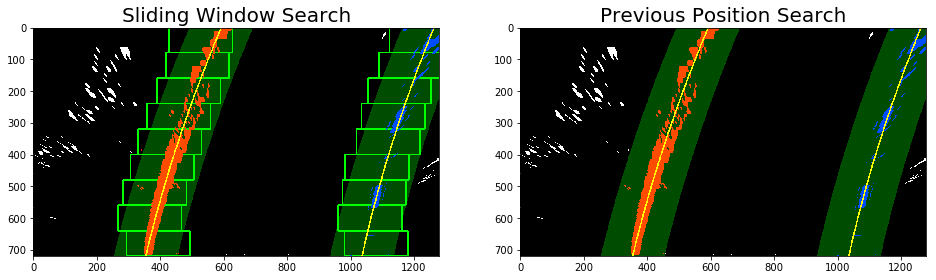

In [13]:
# Generate the fitted line by sliding window search on a binary warped image
images_line_sliding = []
images_line_prev = []

for idx, img in enumerate(images_warped_combine):
    # Generate the sliding window search on a binary warped image
    line_sliding, left_fit, right_fit = sliding_window_search(img, margin=100)
    # Generate the previous line position search on a binary warped image
    line_prev, _, _ = prev_search(img, left_fit, right_fit, margin=100)
    
    images_line_sliding.append(line_sliding)
    images_line_prev.append(line_prev)
    
    write_name = './output_images/test_images/'+'line'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, line_sliding)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.imshow(images_line_sliding[5])
ax1.set_title('Sliding Window Search', fontsize=20)
ax2.imshow(images_line_prev[5])
ax2.set_title('Previous Position Search', fontsize=20)

## Calculation of radius of curvature after correcting for scale in x and y.
Assuming that the lane is about 40 meters long and 3.7 meters wide.

In [14]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 40/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def cal_curvature(img, fit):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])# to cover same y-range as image
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    # Define y-value where we want radius of curvature
    # The maximum y-value is chosen, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, plotx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    curverad = np.round(curverad, 3)
    
    return curverad

def cal_offset_pixel(img, fit):
    # Define y-value where we want radius of curvature
    # The maximum y-value is chosen, corresponding to the bottom of the image
    y_eval = img.shape[0] - 1
    x_eval = fit[0]*y_eval**2 + fit[1]*y_eval + fit[2]
    # Calculate the offset distance in pixel
    # Positive: right side, Negative: left side
    offset = (x_eval - img.shape[1]/2)
    
    return offset

def cal_offset(img, fit):
    offset = cal_offset_pixel(img, fit)*xm_per_pix
    offset = np.round(offset, 3)
    
    return offset

## Draw the image of lane result plotted back down onto the road

In [15]:
def draw_lane_region(undist, Minv, left_fit, right_fit):
    
    # Get the current line fit values
    # left_fit = left_line.current_fit
    # right_fit = right_line.current_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    pts_left = []
    pts_right = []
            
    if left_fit.any():
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    if right_fit.any():
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        
    pts = np.hstack((pts_left, pts_right))

    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int_(pts_left), isClosed=False, color=(255,0,0), thickness=20)
    cv2.polylines(color_warp, np.int_(pts_right), isClosed=False, color=(0,0,255), thickness=20)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

def put_curvature_and_offset(result, left_fit, right_fit):
    
    # Calculate curverad
    left_curverad = cal_curvature(result, left_fit)
    right_curverad = cal_curvature(result, right_fit)
    radius_curvature = (left_curverad + right_curverad)/2
    # Calculate offset
    left_offset = cal_offset(result, left_fit)
    right_offset = cal_offset(result, right_fit)
    offset_distance = (left_offset + right_offset)/2
        
    # Print Radius of Curvature and Offset Distance on the lane result 
    font = cv2.FONT_HERSHEY_SIMPLEX
    if left_curverad and right_curverad:
        str1 = str('Radius of Curvature: '+ str(np.round(radius_curvature, 3)) +'m')
        cv2.putText(result,str1,(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        str2 = str('Left Curvature: '+ str(np.round(left_curverad, 3)) +'m')
        cv2.putText(result,str2,(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
        str3 = str('Right of Curvature: '+ str(np.round(right_curverad, 3)) +'m')
        cv2.putText(result,str3,(50,150), font, 1,(255,255,255),2,cv2.LINE_AA)
        str4 = str('Offset Distance: '+ str(np.round(offset_distance, 3)) + 'm')
        cv2.putText(result,str4,(50,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result

## Detect lane pipeline
###1. Undistort the original image
###2. Binary gradient of the undistorted image
###3. Perspective transform of the binary image
###4. Find lane from the perspective transform image
###5. Plot the lane result back to the undistorted image

In [16]:
# Detect lane pipeline
def find_lane_pipeline(img):
    # Undistort the original image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    # Binary gradient of the undistorted image
    combined_binary, _, _, _, _, _, _, _,_ = combined_thresh(undistorted)
    # Perspective transform of the binary image
    binary_warped, M, Minv = perspective_transform(combined_binary)
    # Find lane from the perspective transform image
    out_img, left_fit, right_fit = sliding_window_search(binary_warped, margin=100)
    # Plot the lane result back to the undistorted image
    result = draw_lane_region(undistorted, Minv, left_fit, right_fit)
    result = put_curvature_and_offset(result, left_fit, right_fit)
    
    return result

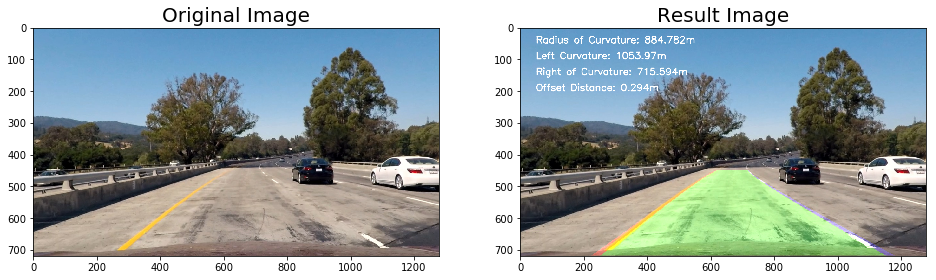

In [17]:
# Read the list of undistorted images, generate the result images
images_result = []

for idx, img in enumerate(images_origin):
    result = find_lane_pipeline(img)
    images_result.append(result)

    write_name = './output_images/test_images/'+'result'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, result)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.imshow(images_undist[0])
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(images_result[0])
ax2.set_title('Result Image', fontsize=20)

# Pipeline (test videos)

In [18]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n=8):
        # number of queue to store data of last iterations
        self.n = n
        # number of fits in last iterations buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n iterations
        self.recent_xfitted = deque([], maxlen=n) 
        # polynomial coefficients of the last n iterations
        self.recent_fit = deque([], maxlen=n)  
        # average x values of the fitted line over the last n iterations
        self.best_xval = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # x values of the most recent fit
        self.current_xval = None   
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # pixels of vehicle center from the line
        self.line_base_pos = deque([], maxlen=n) 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def update_current_fit(self, fit):
        self.current_fit = fit
    
    def update_current_xval(self, img):
        yvals = np.linspace(0, img.shape[0]-1, img.shape[0])
        self.current_xval = self.current_fit[0]*yvals**2 + self.current_fit[1]*yvals + self.current_fit[2]
    
    def update_curvature(self, img):
        self.radius_of_curvature = cal_curvature(img, self.current_fit)
        
    def update_offset(self, img):
        self.line_base_pos = cal_offset_pixel(img, self.current_fit)            
    
    def update_diffs(self):
        if self.n_buffered > 0:
            self.diffs = self.current_fit - self.best_fit
        else:
            self.diffs = np.array([0,0,0], dtype='float') 
            
    def update_best(self, img):
        if len(self.recent_xfitted) > 0:
            self.best_xval = np.mean(self.recent_xfitted, axis=0)
            yvals = np.linspace(0, img.shape[0]-1, img.shape[0])
            xvals = self.best_xval
            self.best_fit = np.polyfit(yvals, xvals, 2)
            
    def add_data(self):
        self.recent_xfitted.appendleft(self.current_xval)
        self.recent_fit.appendleft(self.current_fit)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self):        
        if self.n_buffered > 0:
            self.recent_xfitted.pop()
            self.recent_fit.pop()
            self.n_buffered = len(self.recent_xfitted)

    def update(self, img, fit):
        self.update_current_fit(fit)
        self.update_current_xval(img)
        self.update_diffs()
        self.update_curvature(img)
        self.update_offset(img)
        self.pop_data()
                
    def set_detected(self, img, inp=True):
        self.detected = inp
        if self.detected:
            self.add_data()
            self.update_best(img)
        else:
            if self.n_buffered > 0:
                self.update_best(img)
    
# define left and right lines for detection
left_line = Line()
right_line = Line()

## Sanity Check

####. Checking that they have similar curvature
####. Checking that they are separated by approximately the right distance horizontally
####. Checking that they are roughly parallel

In [19]:
curv_ratio_threshold = 10 # Threshold of the curvature ration between left and right line [1]
distance_max_threshold = 900 # Threshold of the max distance between left and right line [pixel]
distance_min_threshold = 400 # Threshold of the min distance between left and right line [pixel]
distance_deviation_threshold = 200 # Threshold of the standard deviation of distance between left and right line [pixel]

def sanity_check(left_line, right_line):
    # Confirm that the detected lane lines are real
    # Checking that they have similar curvature
    left_curverad = left_line.radius_of_curvature
    right_curverad = right_line.radius_of_curvature
    diff_ratio = left_curverad / right_curverad
    if (diff_ratio >= curv_ratio_threshold) | (diff_ratio <= 1./curv_ratio_threshold):
        return False
    
    # Checking that they are separated by approximately the right distance horizontally
    left_fitx = left_line.current_xval
    right_fitx = right_line.current_xval
    distance = right_fitx - left_fitx
    distance_max = max(distance)
    distance_min = min(distance)
    if (distance_max > distance_max_threshold) | (distance_min < distance_min_threshold):
        return False
    
    # Checking that they are roughly parallel
    distance_deviation = np.std(distance)
    if distance_deviation >= distance_deviation_threshold:
        return False
    
    return True

def find_lane(binary_warped, left_line, right_line):
    
    # Update line data
    if left_line.n_buffered > 0 & right_line.n_buffered > 0:
        # If line buffer exists then use previous best search
        left_fit_last = left_line.best_fit
        right_fit_last = right_line.best_fit
        out_img, left_fit, right_fit = prev_search(binary_warped, left_fit_last, right_fit_last)
    else:
        # If line buffer loses then use sliding window search
        out_img, left_fit, right_fit = sliding_window_search(binary_warped, margin=100)
    
    if left_fit.any() & right_fit.any():
        left_line.update(out_img, left_fit)    
        right_line.update(out_img, right_fit)
        
        # Sanity Check
        if sanity_check(left_line, right_line):
            # If sanity check passes, add current fit to buffer
            left_line.set_detected(out_img, inp=True)
            right_line.set_detected(out_img, inp=True)
        else:
            # If sanity check not passes, ignore the current fit
            left_line.set_detected(out_img, inp=False)
            right_line.set_detected(out_img, inp=False)
    else:
        left_line.set_detected(out_img, inp=False)
        right_line.set_detected(out_img, inp=False)
            
    left_best_fit = left_line.best_fit
    right_best_fit = right_line.best_fit
    
    return out_img, left_best_fit, right_best_fit



## Video processing

In [20]:
def find_lane_pipeline_video(img, y_thresh, w_thresh, diagnosis=True):
    
    # Undistort the original image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    # Perspective transform of the undistorted image
    warped_color, M, Minv = perspective_transform(undistorted)
    # Binary gradient of the warped image
    warped_binary, _, _ = color_thresh(warped_color, y_thresh, w_thresh)
    

    # Find lane from the perspective transform image
    out_img, left_best_fit, right_best_fit = find_lane(warped_binary, left_line, right_line)
    # Plot the lane result back to the undistorted image
    result = draw_lane_region(undistorted, Minv, left_best_fit, right_best_fit)
    result = put_curvature_and_offset(result, left_best_fit, right_best_fit)

    if diagnosis:
        # Calculate the size of screens
        result_screen_w = result.shape[1]
        result_screen_h = result.shape[0]
        diag_screen_w = np.int(result_screen_w / 3)
        diag_screen_h = np.int(result_screen_h / 3)
        screen_w = result_screen_w + diag_screen_w
        screen_h = result_screen_h
        # Assign result image to the screen
        screen = np.zeros((screen_h, screen_w, 3), dtype=np.uint8)
        screen[0:result_screen_h, 0:result_screen_w] = result
        # Assgin diagnosis image to the screen
        diag_img_1 = warped_color
        screen[0:diag_screen_h, result_screen_w:, :] = cv2.resize(diag_img_1, (diag_screen_w, diag_screen_h))
        diag_img_2 = np.dstack((warped_binary, warped_binary, warped_binary))*255
        screen[diag_screen_h : diag_screen_h*2, result_screen_w:, :] = cv2.resize(diag_img_2, (diag_screen_w, diag_screen_h))
        screen[diag_screen_h*2 : diag_screen_h*3, result_screen_w:, :] = cv2.resize(out_img, (diag_screen_w, diag_screen_h))
        return screen
    else: 
        return result

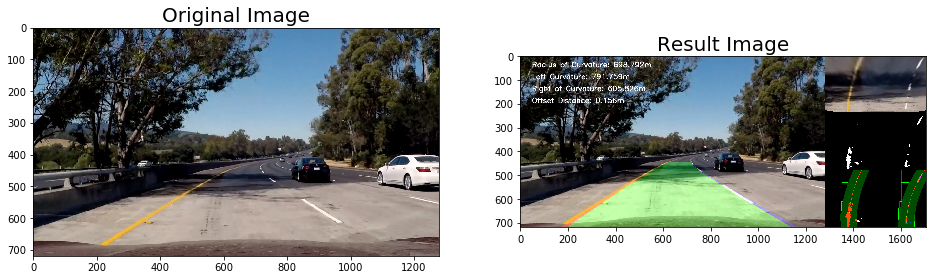

In [29]:
image_test_video = images_origin[4]
image_result_video = find_lane_pipeline_video(image_test_video, (140,255),(200,255), diagnosis=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.imshow(image_test_video)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image_result_video)
ax2.set_title('Result Image', fontsize=20)

## Try the first project test video.

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def find_lane_pipeline_video1(img):
    result = find_lane_pipeline_video(img, (140,255), (200,255), diagnosis=True)
    return result

video_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(find_lane_pipeline_video1)
%time clip.write_videofile(video_output, audio=False)

ImportError: No module named 'moviepy'

## Try the second challenge video.

Capture test images from the challenge video, then test the binary function and perspective transform function.

In [ ]:
# Capture test images from the challenge video.
vc = cv2.VideoCapture("challenge_video.mp4")
time = 0
timePeriod = 25

if vc.isOpened():
    rval, frame = vc.read()
else:
    rval = False
    
 
while rval:
    rval, frame = vc.read()
    if(time%timePeriod == 0):
        cv2.imwrite('test_images/challenge' + str(time) + '.jpg', frame)
    time = time + 1
    cv2.waitKey(1)

vc.release()

In [30]:
# Read the list of challenge test images
images_challenge_test = glob.glob('./test_images/challenge*.jpg')

for idx, fname in enumerate(images_challenge_test):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    lightness = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,1]
    red = img[:,:,0]
    
    write_name = './output_images/challenge_images/'+'gray'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, gray, cmap='gray')
    write_name = './output_images/challenge_images/'+'red'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, red, cmap='gray')
    write_name = './output_images/challenge_images/'+'saturation'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, saturation, cmap='gray')
    write_name = './output_images/challenge_images/'+'lightness'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, lightness, cmap='gray')

## Do perspective transform for challenge images

In [31]:
# Compute the perspective transform and warp the images
def perspective_transform_challenge(img):

    img_size = (img.shape[1], img.shape[0])
        
    # Four source coordinates
    src = np.float32(
        [[285, 720],
         [1125, 720],
         [595, 480],
         [725, 480]])
    # Four desired coordinates
    dst = np.float32(
        [[310, 720],
         [1010, 720],
         [310, 0],
         [1010, 0]])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

def draw_straight_line(img):
    
    cv2.line(img, (285, 720), (595, 480), color=(255,0,0), thickness=1)
    cv2.line(img, (1125, 720), (725, 480), color=(255,0,0), thickness=1)
    
    return img

M = 
 [[ -5.42635659e-01  -1.41182171e+00   9.69302326e+02]
 [ -8.21565038e-15  -1.95348837e+00   9.37674419e+02]
 [ -1.18178037e-17  -2.29328165e-03   1.00000000e+00]]
Minv = 
 [[  1.85714286e-01  -7.65128968e-01   5.37428571e+02]
 [ -2.66453526e-15  -5.11904762e-01   4.80000000e+02]
 [ -4.77048956e-18  -1.17394180e-03   1.00000000e+00]]


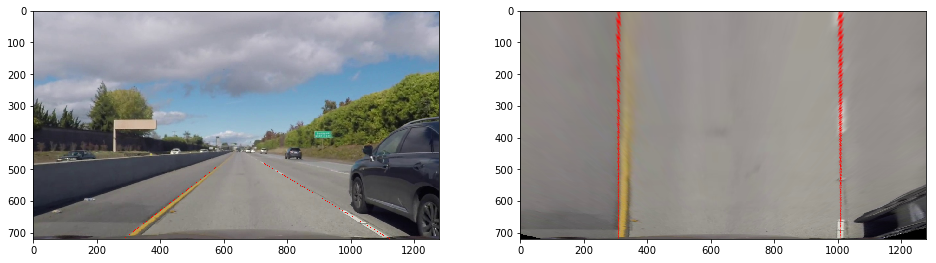

In [32]:
# Test the challenge straight images with perspective transform
img_straight_challenge = mpimg.imread('test_images/challenge475.jpg')
img_straight_challenge = cv2.undistort(img_straight_challenge, mtx, dist, None, mtx)
img_straight_challenge = draw_straight_line(img_straight_challenge)
warped_straight_challenge, M_challenge, Minv_challenge = perspective_transform_challenge(img_straight_challenge)


print('M = \n', M_challenge)
print('Minv = \n', Minv_challenge)

fig = plt.figure(figsize=(16, 8))
fig.add_subplot(1,2,1)
plt.imshow(img_straight_challenge)
fig.add_subplot(1,2,2)
plt.imshow(warped_straight_challenge, cmap='gray')

plt.show()

In [ ]:
def find_lane_pipeline_video_challenge(img, y_thresh, w_thresh, diagnosis=True):
    
    # Undistort the original image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    # Perspective transform of the undistorted image
    warped_color, M, Minv = perspective_transform_challenge(undistorted)
    # Binary gradient of the warped image
    warped_binary, _, _ = color_thresh(warped_color, y_thresh, w_thresh)
    

    # Find lane from the perspective transform image
    out_img, left_best_fit, right_best_fit = find_lane(warped_binary, left_line, right_line)
    # Plot the lane result back to the undistorted image
    result = draw_lane_region(undistorted, Minv, left_best_fit, right_best_fit)
    result = put_lane_curvature_and_offset(result, left_line, right_line)

    if diagnosis:
        # Calculate the size of screens
        result_screen_w = result.shape[1]
        result_screen_h = result.shape[0]
        diag_screen_w = np.int(result_screen_w / 3)
        diag_screen_h = np.int(result_screen_h / 3)
        screen_w = result_screen_w + diag_screen_w
        screen_h = result_screen_h
        # Assign result image to the screen
        screen = np.zeros((screen_h, screen_w, 3), dtype=np.uint8)
        screen[0:result_screen_h, 0:result_screen_w] = result
        # Assgin diagnosis image to the screen
        diag_img_1 = warped_color
        screen[0:diag_screen_h, result_screen_w:, :] = cv2.resize(diag_img_1, (diag_screen_w, diag_screen_h))
        diag_img_2 = np.dstack((warped_binary, warped_binary, warped_binary))*255
        screen[diag_screen_h : diag_screen_h*2, result_screen_w:, :] = cv2.resize(diag_img_2, (diag_screen_w, diag_screen_h))
        screen[diag_screen_h*2 : diag_screen_h*3, result_screen_w:, :] = cv2.resize(out_img, (diag_screen_w, diag_screen_h))
        return screen
    else: 
        return result

In [ ]:
# Read the list of challenge test images
images_challenge_test = glob.glob('./test_images/challenge*.jpg')
images_challenge_origin = []
images_challenge_undist = []
images_challenge_combine = []
images_challenge_binary = []
images_challenge_warped = []
images_challenge_color_warped = []
images_challenge_color_binary = []
images_challenge_result = []

for idx, fname in enumerate(images_challenge_test):
    img = mpimg.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    combined_binary, _, _, _, _, _, _, _, _ = combined_thresh(undist)
    warped, _, _ = perspective_transform_challenge(combined_binary)
    color_warped, _, _ = perspective_transform_challenge(undist)
    combined_channel, yellow_channel, white_channel = combined_color(color_warped)
    color_binary, yellow_bin, white_bin = color_thresh(color_warped, (80,255), (200,255))
    result = find_lane_pipeline_video_challenge(img, (80,255), (200,255), diagnosis=True)
    images_challenge_origin.append(img)
    images_challenge_undist.append(undist)
    images_challenge_binary.append(combined_binary)
    images_challenge_warped.append(warped)
    images_challenge_color_warped.append(color_warped)
    images_challenge_color_binary.append(color_binary)
    images_challenge_result.append(result)
    
    write_name = './output_images/challenge_images/'+'binary_challenge'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, combined_binary, cmap='gray')
    write_name = './output_images/challenge_images/'+'binary_warped'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, warped, cmap='gray')
    write_name = './output_images/challenge_images/'+'color_warped'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, color_warped)
    write_name = './output_images/challenge_images/'+'result'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, result)
    
    # For test of color threshold
    write_name = './output_images/challenge_images/'+'combined_channel'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, combined_channel, cmap='gray')
    write_name = './output_images/challenge_images/'+'yellow_channel'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, yellow_channel, cmap='gray')
    write_name = './output_images/challenge_images/'+'white_channel'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, white_channel, cmap='gray')
    write_name = './output_images/challenge_images/'+'color_bin'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, color_binary, cmap='gray')
    write_name = './output_images/challenge_images/'+'yellow_bin'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, yellow_bin, cmap='gray')
    write_name = './output_images/challenge_images/'+'white_bin'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, white_bin, cmap='gray')

In [ ]:
def find_lane_pipeline_video2(img):
    result = find_lane_pipeline_video_challenge(img, (80,255), (200,255), diagnosis=True)
    cv2.waitKey(100)
    return result

video_output = 'challenge_video_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
clip = clip1.fl_image(find_lane_pipeline_video2)
%time clip.write_videofile(video_output, audio=False)

In [ ]:
# Capture test images from the challenge video.
vc = cv2.VideoCapture("harder_challenge_video.mp4")
time = 0
timePeriod = 50

if vc.isOpened():
    rval, frame = vc.read()
else:
    rval = False
    
 
while rval:
    rval, frame = vc.read()
    if(time%timePeriod == 0):
        cv2.imwrite('test_images/harder_challenge' + str(time) + '.jpg', frame)
    time = time + 1
    cv2.waitKey(1)

vc.release()

In [ ]:
# Read the list of challenge test images
images_hard_test = glob.glob('./test_images/harder_challenge*.jpg')

for idx, fname in enumerate(images_hard_test):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    lightness = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,1]
    red = img[:,:,0]
    
    write_name = './output_images/hard_images/'+'gray'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, gray, cmap='gray')
    write_name = './output_images/hard_images/'+'red'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, red, cmap='gray')
    write_name = './output_images/hard_images/'+'saturation'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, saturation, cmap='gray')
    write_name = './output_images/hard_images/'+'lightness'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, lightness, cmap='gray')

In [ ]:
# Read the list of challenge test images
images_hard_test = glob.glob('./test_images/harder_challenge*.jpg')
images_hard_origin = []
images_hard_undist = []
images_hard_combine = []
images_hard_binary = []
images_hard_warped = []
images_hard_color_warped = []
images_hard_color_binary = []
images_hard_result = []

for idx, fname in enumerate(images_hard_test):
    img = mpimg.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    combined_binary, _, _, _, _, _, _, _, _ = combined_thresh(undist)
    warped, _, _ = perspective_transform_challenge(combined_binary)
    color_warped, _, _ = perspective_transform_challenge(undist)
    combined_channel, yellow_channel, white_channel = combined_color(color_warped)
    color_binary, yellow_bin, white_bin = color_thresh(color_warped, (80,255), (200,255))
    result = find_lane_pipeline_video_challenge(img, (80,255), (200,255), diagnosis=True)
    images_challenge_origin.append(img)
    images_challenge_undist.append(undist)
    images_challenge_binary.append(combined_binary)
    images_challenge_warped.append(warped)
    images_challenge_color_warped.append(color_warped)
    images_challenge_color_binary.append(color_binary)
    images_challenge_result.append(result)
    
    write_name = './output_images/hard_images/'+'binary_challenge'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, combined_binary, cmap='gray')
    write_name = './output_images/hard_images/'+'binary_warped'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, warped, cmap='gray')
    write_name = './output_images/hard_images/'+'color_warped'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, color_warped)
    write_name = './output_images/hard_images/'+'result'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, result)
    
    # For test of color threshold
    write_name = './output_images/hard_images/'+'combined_channel'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, combined_channel, cmap='gray')
    write_name = './output_images/hard_images/'+'yellow_channel'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, yellow_channel, cmap='gray')
    write_name = './output_images/hard_images/'+'white_channel'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, white_channel, cmap='gray')
    write_name = './output_images/hard_images/'+'color_bin'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, color_binary, cmap='gray')
    write_name = './output_images/hard_images/'+'yellow_bin'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, yellow_bin, cmap='gray')
    write_name = './output_images/hard_images/'+'white_bin'+str(idx+1)+'.jpg'
    mpimg.imsave(write_name, white_bin, cmap='gray')

In [ ]:
video_output = 'harder_challenge_video_result.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
clip = clip1.fl_image(find_lane_pipeline_video)
%time clip.write_videofile(video_output, audio=False)